In [132]:
import pandas as pd
import math
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## group weather data

In [2]:
weather = pd.read_csv('weather_data.csv')

In [5]:
weather.columns

Index(['cityid', 'DailySnowDepth', 'DailySnowfall', 'HourlyAltimeterSetting',
       'HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyVisibility', 'HourlyWetBulbTemperature',
       'HourlyWindSpeed', 'Sunrise', 'Sunset', 'day', 'month', 'hour'],
      dtype='object')

In [24]:
weather['SunriseHour'] = weather['Sunrise'].apply(lambda x: int(str(x)[:-2]))
weather['SunriseMinute'] = weather['Sunrise'].apply(lambda x: int(str(x)[-2:]))
weather['SunsetHour'] = weather['Sunset'].apply(lambda x: int(str(x)[:-2]))
weather['SunsetMinute'] = weather['Sunset'].apply(lambda x: int(str(x)[-2:]))

In [27]:
weather['DaylightTime'] = (weather['SunsetHour']-weather['SunriseHour'])*60+(weather['SunsetMinute']-weather['SunriseMinute'])

In [31]:
weather_group = weather.groupby(['cityid','month','hour'])[['DailySnowDepth', 'DailySnowfall',
       'HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyVisibility', 'HourlyWetBulbTemperature',
       'HourlyWindSpeed','DaylightTime']].mean().reset_index()

In [32]:
weather_group.head()

,cityid,month,hour,DailySnowDepth,DailySnowfall,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindSpeed,DaylightTime
0,1,1,0,0.0,0.026316,17.684211,21.157895,0.001707,8.026842,19.789474,9.710526,632.736842
1,1,1,1,0.0,0.023256,20.837209,23.837209,0.002571,7.860465,22.697674,8.441860,634.023256
2,1,1,2,0.0,0.021739,20.434783,23.434783,0.004250,6.972826,22.413043,9.130435,636.913043
3,1,1,3,0.0,0.025641,18.102564,21.384615,0.004474,7.397436,20.333333,9.102564,633.358974
4,1,1,4,0.0,0.022222,20.511111,23.222222,0.012250,7.066667,22.200000,8.488889,637.066667


In [61]:
weather_group.columns = ['cityid', 'Month', 'Hour', 'DailySnowDepth', 'DailySnowfall',
       'HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyVisibility', 'HourlyWetBulbTemperature',
       'HourlyWindSpeed', 'DaylightTime']

## merge with train/test data

In [33]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [47]:
train.dtypes

RowId                        int64
IntersectionId               int64
Latitude                   float64
Longitude                  float64
EntryStreetName             object
ExitStreetName              object
EntryHeading                object
ExitHeading                 object
Hour                         int64
Weekend                      int64
Month                        int64
Path                        object
TotalTimeStopped_p20         int64
TotalTimeStopped_p40         int64
TotalTimeStopped_p50         int64
TotalTimeStopped_p60         int64
TotalTimeStopped_p80         int64
TimeFromFirstStop_p20        int64
TimeFromFirstStop_p40        int64
TimeFromFirstStop_p50        int64
TimeFromFirstStop_p60        int64
TimeFromFirstStop_p80        int64
DistanceToFirstStop_p20    float64
DistanceToFirstStop_p40    float64
DistanceToFirstStop_p50    float64
DistanceToFirstStop_p60    float64
DistanceToFirstStop_p80    float64
City                        object
dtype: object

In [51]:
# exclude 'Philadelphia'
train = train[train.City!='Philadelphia']
test = test[test.City!='Philadelphia']

In [56]:
# encoding cityid
train['cityid'] = ''
train.loc[train.City=='Atlanta','cityid'] = 3
train.loc[train.City=='Boston','cityid'] = 2
train.loc[train.City=='Chicago','cityid'] = 1

In [59]:
test['cityid'] = ''
test.loc[test.City=='Atlanta','cityid'] = 3
test.loc[test.City=='Boston','cityid'] = 2
test.loc[test.City=='Chicago','cityid'] = 1

In [68]:
# add distance from city centers
def add_distance(df): 
    df_center = pd.DataFrame({"Atlanta":[33.753746, -84.386330],
                             "Boston":[42.361145, -71.057083],
                             "Chicago":[41.881832, -87.623177]})
    
    df["CenterDistance"] = df.apply(lambda row: math.sqrt((df_center[row.City][0] - row.Latitude) ** 2 +
                                                          (df_center[row.City][1] - row.Longitude) ** 2) , axis=1)

add_distance(train)
add_distance(test)

In [70]:
# merge with weather data
train_weather = pd.merge(train, weather_group, on=['cityid', 'Month', 'Hour'],how='left')
test_weather = pd.merge(test, weather_group, on=['cityid', 'Month', 'Hour'],how='left')

In [73]:
train_weather.columns = ['RowId', 'IntersectionId', 'Latitude', 'Longitude', 'EntryStreetName',
       'ExitStreetName', 'EntryHeading', 'ExitHeading', 'Hour', 'Weekend',
       'Month', 'Path', 'TotalTimeStopped_p20', 'TotalTimeStopped_p40',
       'TotalTimeStopped_p50', 'TotalTimeStopped_p60', 'TotalTimeStopped_p80',
       'TimeFromFirstStop_p20', 'TimeFromFirstStop_p40',
       'TimeFromFirstStop_p50', 'TimeFromFirstStop_p60',
       'TimeFromFirstStop_p80', 'DistanceToFirstStop_p20',
       'DistanceToFirstStop_p40', 'DistanceToFirstStop_p50',
       'DistanceToFirstStop_p60', 'DistanceToFirstStop_p80', 'City', 'Cityid',
       'CenterDistance', 'DailySnowDepth', 'DailySnowfall',
       'HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyVisibility', 'HourlyWetBulbTemperature',
       'HourlyWindSpeed', 'DaylightTime']

In [76]:
test_weather.columns = ['RowId', 'IntersectionId', 'Latitude', 'Longitude', 'EntryStreetName',
       'ExitStreetName', 'EntryHeading', 'ExitHeading', 'Hour', 'Weekend',
       'Month', 'Path', 'City', 'Cityid', 'CenterDistance', 'DailySnowDepth',
       'DailySnowfall', 'HourlyDewPointTemperature',
       'HourlyDryBulbTemperature', 'HourlyPrecipitation', 'HourlyVisibility',
       'HourlyWetBulbTemperature', 'HourlyWindSpeed', 'DaylightTime']

In [79]:
train_weather.to_csv('train_weather.csv',index=False)
test_weather.to_csv('test_weather.csv',index=False)

## sample

In [18]:
data = pd.read_csv('/Users/Loielaine/Desktop/umich-2019/EECS545/project/data/train_weather.csv')

In [20]:
data.shape

(468852, 39)

In [19]:
data = data[data.Month!=1]

In [42]:
len(data.IntersectionId.unique())

2397

In [31]:
float(10000)/float(468852)

0.02132869220990846

In [28]:
data.groupby(['Cityid']).count()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,...,CenterDistance,DailySnowDepth,DailySnowfall,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindSpeed,DaylightTime
Cityid,,,,,,,,,,,,,,,,,,,,,
1,133674,133674,133674,133674,132944,133018,133674,133674,133674,133674,...,133674,133674,133674,133674,133674,133674,133674,133674,133674,133674
2,182027,182027,182027,182027,180375,181029,182027,182027,182027,182027,...,182027,182023,182023,182023,182023,182023,182023,182023,182023,182023
3,153151,153151,153151,153151,150019,150675,153151,153151,153151,153151,...,153151,153103,153103,153103,153103,153103,153103,153103,153103,153103


In [41]:
type(list(data.loc[data.Cityid==i,'RowId']))

list

In [68]:
sample = pd.DataFrame(columns = data.columns)
for i in [1,2,3]:
    IntersectionId = data.loc[data.Cityid==i,'IntersectionId'].unique()
    index = np.random.choice(IntersectionId, size = int(len(IntersectionId)*0.025) ,replace=False)
    s = data[(data.Cityid==i)&(data.IntersectionId.isin(index))]
    sample = sample.append(s)  

In [69]:
sample[sample.Month<12].shape

(10806, 39)

In [145]:
train_sample, test_sample = train_test_split(sample, test_size=0.2,stratify = sample['IntersectionId'])

In [146]:
train_sample.shape

(10197, 39)

## Encoding

In [166]:
X_train = train_sample.drop(['RowId','EntryStreetName','Path',
       'ExitStreetName','TotalTimeStopped_p20', 'TotalTimeStopped_p40',
       'TotalTimeStopped_p50', 'TotalTimeStopped_p60', 'TotalTimeStopped_p80',
       'TimeFromFirstStop_p20', 'TimeFromFirstStop_p40',
       'TimeFromFirstStop_p50', 'TimeFromFirstStop_p60',
       'TimeFromFirstStop_p80', 'DistanceToFirstStop_p20',
       'DistanceToFirstStop_p40', 'DistanceToFirstStop_p50',
       'DistanceToFirstStop_p60', 'DistanceToFirstStop_p80'],axis=1)

In [167]:
X_test = test_sample.drop(['RowId','EntryStreetName','Path',
       'ExitStreetName','TotalTimeStopped_p20', 'TotalTimeStopped_p40',
       'TotalTimeStopped_p50', 'TotalTimeStopped_p60', 'TotalTimeStopped_p80',
       'TimeFromFirstStop_p20', 'TimeFromFirstStop_p40',
       'TimeFromFirstStop_p50', 'TimeFromFirstStop_p60',
       'TimeFromFirstStop_p80', 'DistanceToFirstStop_p20',
       'DistanceToFirstStop_p40', 'DistanceToFirstStop_p50',
       'DistanceToFirstStop_p60', 'DistanceToFirstStop_p80'],axis=1)

In [168]:
X_train.shape

(10197, 20)

In [169]:
X_test.shape

(2550, 20)

In [170]:
# onehot encoding
def OnehotEncoding(X):
    X_1 = X[['Cityid','EntryHeading', 'ExitHeading']]
    le = preprocessing.LabelEncoder()
    X_2 = X_1.apply(le.fit_transform)
    enc = preprocessing.OneHotEncoder()
    enc.fit(X_2)
    X_enc = enc.transform(X_2).toarray()

    X = X.drop(['Cityid','EntryHeading','ExitHeading','City'], axis=1).values
    X = np.c_[X_enc,X]
    return X

In [171]:
X_train = OnehotEncoding(X_train)
X_test = OnehotEncoding(X_test)

In [172]:
y_train = train_sample[['TotalTimeStopped_p50', 'TotalTimeStopped_p80']].values
y_test = test_sample[['TotalTimeStopped_p50', 'TotalTimeStopped_p80']].values

In [173]:
y_train.shape

(10197, 2)

In [174]:
train = np.concatenate((X_train, y_train),axis=1)

In [175]:
test = np.concatenate((X_test, y_test),axis=1)

In [176]:
# remove nan, infinite
def Remove(X):
    X = X.astype(float)
    X_t = X[~np.isnan(X).any(axis=1), :]
    return X_t

In [177]:
train_t = Remove(train)
test_t = Remove(test)

In [178]:
train_t.shape

(10197, 37)

In [180]:
test.shape

(2550, 37)

In [181]:
np.savetxt('train_sample2.csv', train, delimiter=',')
np.savetxt('test_sample2.csv', test, delimiter=',')

## Sample without weather data

In [70]:
data = sample.copy()

In [103]:
X_train = data[data.Month<12].drop(['RowId','EntryStreetName','Path',
       'ExitStreetName','TotalTimeStopped_p20', 'TotalTimeStopped_p40',
       'TotalTimeStopped_p50', 'TotalTimeStopped_p60', 'TotalTimeStopped_p80',
       'TimeFromFirstStop_p20', 'TimeFromFirstStop_p40',
       'TimeFromFirstStop_p50', 'TimeFromFirstStop_p60',
       'TimeFromFirstStop_p80', 'DistanceToFirstStop_p20',
       'DistanceToFirstStop_p40', 'DistanceToFirstStop_p50',
       'DistanceToFirstStop_p60', 'DistanceToFirstStop_p80','DailySnowDepth', 'DailySnowfall',
       'HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyVisibility', 'HourlyWetBulbTemperature',
       'HourlyWindSpeed', 'DaylightTime'],axis=1)

In [104]:
X_test = data[data.Month==12].drop(['RowId','EntryStreetName','Path',
       'ExitStreetName','TotalTimeStopped_p20', 'TotalTimeStopped_p40',
       'TotalTimeStopped_p50', 'TotalTimeStopped_p60', 'TotalTimeStopped_p80',
       'TimeFromFirstStop_p20', 'TimeFromFirstStop_p40',
       'TimeFromFirstStop_p50', 'TimeFromFirstStop_p60',
       'TimeFromFirstStop_p80', 'DistanceToFirstStop_p20',
       'DistanceToFirstStop_p40', 'DistanceToFirstStop_p50',
       'DistanceToFirstStop_p60', 'DistanceToFirstStop_p80','DailySnowDepth', 'DailySnowfall',
       'HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyVisibility', 'HourlyWetBulbTemperature',
       'HourlyWindSpeed', 'DaylightTime'],axis=1)

In [105]:
X_train.shape

(10806, 11)

In [106]:
X_test.shape

(1941, 11)

In [107]:
# onehot encoding
def OnehotEncoding(X):
    X_1 = X[['Cityid','EntryHeading', 'ExitHeading']]
    le = preprocessing.LabelEncoder()
    X_2 = X_1.apply(le.fit_transform)
    enc = preprocessing.OneHotEncoder()
    enc.fit(X_2)
    X_enc = enc.transform(X_2).toarray()

    X = X.drop(['Cityid','EntryHeading','ExitHeading','City'], axis=1).values
    X = np.c_[X_enc,X]
    return X

In [108]:
X_train = OnehotEncoding(X_train)
X_test = OnehotEncoding(X_test)

In [128]:
y_train = data.loc[data.Month<12,['TotalTimeStopped_p20', 'TotalTimeStopped_p80']].values
y_test = data.loc[data.Month==12,['TotalTimeStopped_p20', 'TotalTimeStopped_p80']].values

In [122]:
y_train.shape

(10806, 2)

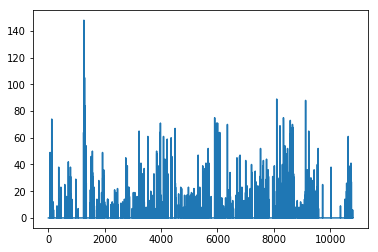

In [129]:
plt.plot(y_train[:,0])
plt.show()

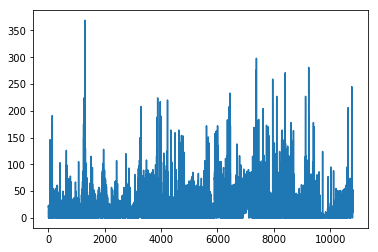

In [125]:
plt.plot(y_train[:,1])
plt.show()

In [110]:
y_train.shape

(10806, 2)

In [111]:
train = np.concatenate((X_train, y_train),axis=1)

In [112]:
test = np.concatenate((X_test, y_test),axis=1)

In [113]:
np.savetxt('train_sample_no_weather.csv', train, delimiter=',')
np.savetxt('test_sample_no_weather.csv', test, delimiter=',')

## Encoding

In [70]:
data = sample.copy()

In [81]:
X_train = data[data.Month<12].drop(['RowId','EntryStreetName','Path',
       'ExitStreetName','TotalTimeStopped_p20', 'TotalTimeStopped_p40',
       'TotalTimeStopped_p50', 'TotalTimeStopped_p60', 'TotalTimeStopped_p80',
       'TimeFromFirstStop_p20', 'TimeFromFirstStop_p40',
       'TimeFromFirstStop_p50', 'TimeFromFirstStop_p60',
       'TimeFromFirstStop_p80', 'DistanceToFirstStop_p20',
       'DistanceToFirstStop_p40', 'DistanceToFirstStop_p50',
       'DistanceToFirstStop_p60', 'DistanceToFirstStop_p80'],axis=1)

In [82]:
X_test = data[data.Month==12].drop(['RowId','EntryStreetName','Path',
       'ExitStreetName','TotalTimeStopped_p20', 'TotalTimeStopped_p40',
       'TotalTimeStopped_p50', 'TotalTimeStopped_p60', 'TotalTimeStopped_p80',
       'TimeFromFirstStop_p20', 'TimeFromFirstStop_p40',
       'TimeFromFirstStop_p50', 'TimeFromFirstStop_p60',
       'TimeFromFirstStop_p80', 'DistanceToFirstStop_p20',
       'DistanceToFirstStop_p40', 'DistanceToFirstStop_p50',
       'DistanceToFirstStop_p60', 'DistanceToFirstStop_p80'],axis=1)

In [83]:
X_train.shape

(10806, 20)

In [84]:
X_test.shape

(1941, 20)

In [80]:
# onehot encoding
def OnehotEncoding(X):
    X_1 = X[['Cityid','EntryHeading', 'ExitHeading']]
    le = preprocessing.LabelEncoder()
    X_2 = X_1.apply(le.fit_transform)
    enc = preprocessing.OneHotEncoder()
    enc.fit(X_2)
    X_enc = enc.transform(X_2).toarray()

    X = X.drop(['Cityid','EntryHeading','ExitHeading','City'], axis=1).values
    X = np.c_[X_enc,X]
    return X

In [75]:
X.shape

(12747, 35)

In [85]:
X_train = OnehotEncoding(X_train)
X_test = OnehotEncoding(X_test)

In [90]:
y_train = data.loc[data.Month<12,['TotalTimeStopped_p50', 'TotalTimeStopped_p80']].values
y_test = data.loc[data.Month==12,['TotalTimeStopped_p50', 'TotalTimeStopped_p80']].values

In [91]:
y_train.shape

(10806, 2)

In [94]:
train = np.concatenate((X_train, y_train),axis=1)

In [96]:
test = np.concatenate((X_test, y_test),axis=1)

In [101]:
np.savetxt('train_sample.csv', train, delimiter=',')
np.savetxt('test_sample.csv', test, delimiter=',')